In [1]:
import pandas as pd
import numpy as np
import json
import operator
import itertools 
import matplotlib.pyplot as plt
import re
import subprocess
import seaborn as sns

In [2]:
dataDir="./datasets/"
datasets=[
    "adult",
    "airport",
    "flights",
    "food",
    "Hospital",
    "inspection",
    "ncvoter",
    "SPStock",
    "tax500k",
]

In [3]:
JARDir="./algorithmJARs/"
algorithms=[
    "FastDC",
    "Hydra",
    "DCFinder",
    "ADCMiner",
    "FastADC",
]

In [4]:
aproximations=["0.00","0.00000001","0.000001","0.0001","0.01"]
aproxexp=["0","10^{-8}","10^{-6}","10^{-4}","10^{-2}"]

In [5]:
supbase=np.linspace(-8,0,1000)
supports=np.array([0]+list(np.power(10,supbase)))

# Code

## Dataset

In [6]:
class Dataset:
    def __init__(self,file,**args):
        self.columns=pd.read_csv(file,nrows=0).columns
        self.header=[re.match(r'([^\(\)]*)(?:\(| )([^\(\)]*)\)?',col) for col in self.columns]
        self.names=[match[1] for match in self.header]
        typeMap={'String':str,'Integer':float,'Int':float,'Double':float,'int':float,'str':str,'float':float}
        self.types={col:typeMap[match[2]] for col,match in zip(self.columns,self.header)}
        
        self.df=pd.read_csv(file,**args,dtype=self.types)
        for i,col in enumerate(self.columns):
            self.df[col]=self.df[col].astype(self.types[col])
        
    def randRows(self,n):
        ids=np.random.randint(0,len(self.df),n)
        return self.df.iloc[ids]
    def randFields(self,n):
        return pd.DataFrame({col:dfs[col].iloc[list(np.random.randint(0,len(dfs),n))].values for dfs in [self.df] for col in dfs.columns})

    def buildPLIs(self):
        self.PLI= {col:self.df.groupby(by=col).groups for col in self.df}
        self.PLILen={col:np.array([len(self.PLI[col][v])for v in self.PLI[col]]) for col in self.df}
        self.vals={col:np.array([v for v in self.PLI[col]]) for col in self.df}
    def shuffle(self):
        self.df=self.randFields(len(self.df))

## DenialConstraintResult

In [7]:
class Operator:
    def __init__(self,func,expFunc,smpFunc=None) -> None:
        self.func=func
        self.expFunc=expFunc
        self.smpFunc=smpFunc
        self.neg=None
        self.imp=None
    def __call__(self,a,b):
        return self.func(a,b)
    def negate(self):
        return Operator(operator.invert(self.func))
    def expected(self,c1,c2):
        return self.expFunc(c1,c2)
    def __repr__(self) -> str:
        return self.func.__name__
    def __eq__(self, other: object) -> bool:
        if isinstance(other, Operator):
            return self.func==other.func
        return False
    def __hash__(self):
        fields=(self.func)
        hash_value = hash(fields)
        return hash_value

def eqExp(l,r):
    n=sum(l)**2
    return np.sum(l**2)/n

def eqSmp(vals,PLI,PLILen):
    prob=PLILen**2
    prob=prob/prob.sum()
    while True:
        v=np.random.choice(vals,10000,replace=True,p=prob)
        for vl in v:
            vl=PLI[vl]
            i,j=np.random.randint(0,len(vl),size=2)
            yield vl[i],vl[j]

       

eq=Operator(operator.eq,eqExp,eqSmp)

def neExp(l,r):
    n=sum(l)
    return 1-np.sum(l**2)/n**2
ne=Operator(operator.ne,neExp)

def geExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(cumFreq))/n**2
ge=Operator(operator.ge,geExp)

def leExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(n-cumFreq+l))/n**2
le=Operator(operator.le,leExp)

def gtExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(cumFreq-l))/n**2
gt=Operator(operator.gt,gtExp)

def ltExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(n-cumFreq))/n**2
lt=Operator(operator.lt,ltExp)
operatorMap={
    "EQUAL":eq,
    "UNEQUAL":ne,
    "LESS_EQUAL":le,
    "GREATER_EQUAL":ge,
    "LESS":lt,
    "GREATER":gt
}


eq.neg=ne
ne.neg=eq
gt.neg=le
le.neg=gt
lt.neg=ge
ge.neg=lt

eq.imp=[ge,le,eq]
ne.imp=[ne]
gt.imp=[gt,ge,ne]
lt.imp=[lt,le,ne]
ge.imp=[ge]
le.imp=[le]


class Predicate:
    def __init__(self,l:str,op:Operator,r:str) -> None:
        self.l=l
        self.r=r
        self.op=op
        self.exp=None
    def eval(self,df,t0,t1):
        return self.op(t0[self.l],t1[self.r])
    def expected(self,df):
        if self.exp is None:
            self.exp=self.op.expected(df.PLILen[self.l],None)
        return self.exp
    def sample(self,df):
        if self.op.smpFunc is not None:
            return self.op.smpFunc(df.vals[self.l],df.PLI[self.l],df.PLILen[self.l])
        else:
            return self.defSmp(df)
           
    def defSmp(self,df):
        while(True):
            v=np.random.choice(len(df.df),(10000,2),replace=True)
            t0s=df.df.loc[v[:,0],[self.l]].reset_index()
            t1s=df.df.loc[v[:,1],[self.r]].reset_index()
            res=self.eval(df,t0s,t1s)
            for (i,j),r in zip(v,res):
                if r:
                    yield (i,j)

            
    
    def __repr__(self) -> str:
        return '"'+self.l +'" '+self.op.__repr__()+' "'+self.r+'"'
    def __hash__(self):
        fields=(self.l,self.r)
        hash_value = hash(fields)
        return hash_value

    def __eq__(self, other):
        if isinstance(other, Predicate):
            sFields=(self.l,self.op,self.r)
            oFields=(other.l,other.op,other.r)
            return sFields==oFields
        return False


class DenialConstraint:
    def __init__(self,preds) -> None:
        self.preds=preds
    def eval(self,df,t0,t1):
        return sum([pred.eval(df,t0,t1) for pred in self.preds])
    def coverage(self,df,t0s,t1s):
        pos,neg=0,0
        num=self.eval(df,t0s,t1s)
        dclen=len(self.preds)
        pos=(num==dclen).sum()
        neg=(num<dclen).sum()

                
        return neg/(pos+neg)
    def sampleCoverage(self,df,n=None):
        nn=len(df.df)
        if n is None:
            n=nn**2
        t0s = np.random.randint(0,len(df.df),n)
        t1s = np.random.randint(0,len(df.df),n)
        t1s=(t1s+(t1s==t0s)*np.random.randint(1,len(df.df),n))%len(df.df)
        return self.coverage(df,df.df.loc[t0s].reset_index(),df.df.loc[t1s].reset_index())
    def expCoverage(self,df):
        return 1-np.prod([pred.expected(df) for pred in self.preds])
    def __repr__(self) -> str:
        return "!["+" & ".join([pred.__repr__() for pred in self.preds])+"]"


class DenialConstraintSet:
    def __init__(self,path,dataset,algorithm) -> None:        
        self.predicates={}
        opmap={"==":eq,"<>":ne,">=":ge,"<=":le,">":gt,"<":lt}
        def getPred(c1,op,c2):
            if (c1,c2,op) not in self.predicates:
                self.predicates[(c1,c2,op)]=Predicate(c1,opmap[op],c2)
            return self.predicates[(c1,c2,op)]
        
        self.DCs=[]
        
        with open(path) as f:
            for line in f:
                line=line.strip()[2:-1] #strip !(...)
                preds=line.split('^')
                regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'
                if algorithm in ['ADCMiner','FastADC']:
                    regex=r't0\.([^=><]*) (==|<>|>=|<=|>|<) t1\.([^=><]*)'
                preds = [getPred(*re.match(regex,pred).groups()) for pred in preds]
                self.DCs.append(DenialConstraint(preds))


# Result generation

## Discover DCs

In [8]:
i=0
start=1
for dataset in datasets:
    for algorithm in algorithms:
        for aprox in ["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]:
            i+=1
            if i<start:
                continue
            print(f"---------------ITERATION: {i}")
            print("RUN: {}_{}_{}".format(algorithm,dataset,aprox))
            command='java -Xmx12g -jar {} {} {} 30000'.format(JARDir+algorithm+'.jar',dataDir+dataset+".csv",aprox)
            result = subprocess.run(command, shell=True)
            print("MOVE: {}_{}_{}".format(algorithm,dataset,aprox))
            command='mv output.txt results/{}_{}_{}'.format(algorithm,dataset,aprox)
            result = subprocess.run(command, shell=True)



---------------ITERATION: 1
RUN: FastDC_adult_0.00
20:31:00.683 [main] INFO  de.hpi.naumann.dc.input.Input - rebuild: 75


KeyboardInterrupt: 

20:44:06.841 [main] INFO  d.h.n.d.c.FastDCMinimalCoverSearch - Building DCs ...

Lines written to file successfully!


## Compute support on random samples

In [8]:
#load datasets
dss={}
for dataset in datasets:
    print(dataset)
    dss[dataset]=Dataset(dataDir+dataset+".csv",nrows=20000,encoding='unicode_escape')
    dss[dataset].buildPLIs()

adult
airport
flights
food
Hospital
inspection
ncvoter
SPStock
tax500k


In [56]:
results={}
for algorithm in algorithms[1:]:
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm!='Hydra' else ["0.00"]
    for aprox in aproxs:
        for dataset in datasets:
            print("{}_{}_{}".format(algorithm,dataset,aprox))
            
            dcs=DenialConstraintSet("results/{}_{}_{}".format(algorithm,dataset,aprox),dataset,algorithm)
            n=10000
            
            t0s=dss[dataset].randFields(n)
            t1s=dss[dataset].randFields(n)
            res=[]
            for dc in dcs.DCs:
                sup=dc.coverage(dcs,t0s,t1s)
                res.append(sup)
            results[(algorithm,dataset,aprox)]=res


Hydra_adult_0.00


FileNotFoundError: [Errno 2] No such file or directory: 'results/Hydra_adult_0.00'

In [33]:
#results={}
for algorithm in algorithms[0:1]:
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]
    for aprox in aproxs:
        for dataset in datasets:
            print("{}_{}_{}".format(algorithm,dataset,aprox))
            
            dcs=DenialConstraintSet("results/{}_{}_{}".format(algorithm,dataset,aprox),dataset,algorithm)
            n=10000
            
            t0s=dss[dataset].randFields(n)
            t1s=dss[dataset].randFields(n)
            res=[]
            for dc in dcs.DCs:
                sup=dc.coverage(dcs,t0s,t1s)
                res.append(sup)
            results[(f"{algorithm}_{dataset}_{aprox}")]=res


FastDC_adult_0.00
FastDC_airport_0.00
FastDC_flights_0.00
FastDC_food_0.00
FastDC_Hospital_0.00
FastDC_inspection_0.00
FastDC_ncvoter_0.00
FastDC_SPStock_0.00
FastDC_tax500k_0.00


In [35]:
with open("results/DCSups.json", 'w') as json_file:
        json.dump(results, json_file, indent=4)

In [36]:
import json
with open("results/DCSups.json") as f:
    results=json.load(f)

In [37]:
algDf={}
DCsups={}
for algorithm in algorithms[:]:
    dfs=[]
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]
    sups=np.array(supports)
    for aprox in aproxs:
        df={}
        for dataset in datasets:
            key="_".join([algorithm,dataset,aprox])
            res=results[key]
            

            counts=np.zeros_like(sups)
            for sup in res:
                sup=sup
                counts+=1-sup<=sups
            DCsups[key]=counts/len(res)
            counts[1:]=counts[1:]-counts[:-1]

            
            
            df[dataset]=counts/counts.sum()
        dfs.append(pd.DataFrame(df,index=[sups]).transpose())
    algDf[algorithm]=dfs

In [57]:
supbase=np.linspace(-8,0,1000)
supports=np.array([0]+list(np.power(10,supbase)))
width=13
height=2
yspace=0.3
xspace=0.2
barwidth=0.17

legendwidth=0.5

def tikzFigure(DCsups):
    res=""
    res+="\\begin{tikzpicture}\n"
    res+="".join(tikzAlgorithm(a) for a in range(len(algorithms)))
    res+=tikzLegend(width+1.,-(height +yspace)*(len(algorithms)-1) - height)
    res+="\\end{tikzpicture}\n"
    return res
def tikzAlgorithm(a):
    x=0
    y=-(height +yspace)*a - height
    res=""
    
    res+="".join(tikzDataset(a,d,x,y) for d in range(len(datasets)))
    res+=f"\\draw ({x},{y}) rectangle ++({width},{height});\n"
    res+=f"\\node[rotate=90] at ({x-0.2},{y+height/2}) {{ \\small {algorithms[a]} }};\n"
    return res

def tikzDataset(a,d,x0,y0):
    x=x0+width/len(datasets)*(d+0.5) 

    res=""
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a] not in ['Hydra','FastDC'] else ["0.00"]
    res+="".join(tikzThreshold(a,d,t,x,y0) for t in range(len(aproxs)))
    if a in [4]:
        res+=f"\\node at ({x},{y0-1}) {{ \\small {datasets[d]} }};\n"
    return res

def tikzThreshold(a,d,t,x0,y0):
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a] not in ['Hydra','FastDC'] else ["0.00"]
    x=x0 +(width/len(datasets)-2*xspace)/len(aproxs) * (t-len(aproxs)//2)
    key="_".join([algorithms[a],datasets[d],aproxs[t]])
    sup=DCsups[key]
    res=""
    y=0
    for s in range(len(supports)):
        h=sup[s]-y
        if h<0.01:
            continue        
        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{s/len(supports)*0.8 + 0.1},1,1}};\n"
        res+=f"\\fill[mycolor] ({x},{y0+y*height-1e-2}) rectangle ({x+barwidth},{y0+sup[s]*height+1e-2});\n"
        ss=s
        y=sup[s]
    if a in [4]:
        res+=f"\\node[anchor=west,rotate=-90] at ({x+0.085},{y0-0.02}) {{ \\tiny ${aproxexp[t]}$ }};\n"

    return res

def tikzLegend(x0,y0):
    res=""
    
    for s in range(1,len(supports)):

        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{s/len(supports)*0.8 + 0.1},1,1}};\n"
        res+=f"\\fill[mycolor] ({x0},{y0*(1-(s-1)/(len(supports)-1))-1e-2}) rectangle ({x0+legendwidth},{y0*(1-s/(len(supports)-1))+1e-2});\n"

    ticks=np.array(list(np.round(np.linspace(supbase[0],supbase[-1],5))))
    for s,b in enumerate(ticks):
        res+=f"\\node[align=left] at ({x0-0.3},{y0*(1-s/(len(ticks)-1))}) {{ \\tiny $10^{{{int(b)}}}$ }};\n"

    res+=f"\\draw ({x0},{y0}) rectangle ({x0+legendwidth},{0});\n"
    return res
print(tikzFigure(DCsups))


\begin{tikzpicture}
\definecolor{mycolor}{hsb}{0.1,1,1};
\fill[mycolor] (0.7222222222222222,-2.01) rectangle (0.8922222222222222,0.00633699633699635);
\definecolor{mycolor}{hsb}{0.1,1,1};
\fill[mycolor] (2.1666666666666665,-2.01) rectangle (2.3366666666666664,-0.6566666666666667);
\definecolor{mycolor}{hsb}{0.5003996003996004,1,1};
\fill[mycolor] (2.1666666666666665,-0.6766666666666667) rectangle (2.3366666666666664,-0.4185714285714286);
\definecolor{mycolor}{hsb}{0.6450549450549451,1,1};
\fill[mycolor] (2.1666666666666665,-0.4385714285714286) rectangle (2.3366666666666664,-0.3709523809523809);
\definecolor{mycolor}{hsb}{0.6474525474525474,1,1};
\fill[mycolor] (2.1666666666666665,-0.39095238095238094) rectangle (2.3366666666666664,-0.32333333333333325);
\definecolor{mycolor}{hsb}{0.6922077922077923,1,1};
\fill[mycolor] (2.1666666666666665,-0.34333333333333327) rectangle (2.3366666666666664,-0.2757142857142858);
\definecolor{mycolor}{hsb}{0.7033966033966034,1,1};
\fill[mycolor] (2.16666

In [59]:
supbase=np.linspace(-8,0,1000)
supports=np.array([0]+list(np.power(10,supbase)))
width=13
height=2
yspace=0.3
xspace=0.2
barwidth=0.17

legendwidth=0.5

def tikzFigure(DCsups):
    res=""
    res+="\\begin{tikzpicture}\n"
    res+="".join(tikzAlgorithm(a) for a in range(len(algorithms)))
    res+="\\end{tikzpicture}\n"
    return res
def tikzAlgorithm(a):
    x=0
    y=-(height +yspace)*a - height
    res=""
    
    res+="".join(tikzDataset(a,d,x,y) for d in range(len(datasets)))
    res+=f"\\draw ({x},{y}) rectangle ++({width},{height});\n"
    res+=f"\\node[rotate=90] at ({x-0.2},{y+height/2}) {{ \\small {algorithms[a]} }};\n"
    return res

def tikzDataset(a,d,x0,y0):
    x=x0+width/len(datasets)*(d+0.5) 

    res=""
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a] not in ['Hydra','FastDC'] else ["0.00"]
    res+="".join(tikzThreshold(a,d,t,x,y0) for t in range(len(aproxs)))
    if a in [4]:
        res+=f"\\node at ({x},{y0-1}) {{ \\small {datasets[d]} }};\n"
    return res

def tikzThreshold(a,d,t,x0,y0):
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a] not in ['Hydra','FastDC'] else ["0.00"]
    x=x0 +(width/len(datasets)-2*xspace)/len(aproxs) * (t-len(aproxs)//2)
    key="_".join([algorithms[a],datasets[d],aproxs[t]])
    sup=DCsups[key]
    res=""
    y=0
    for s in range(len(supports)):
        h=sup[s]-y
        if h<0.01:
            continue        
        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{0 if supports[s]<=float(aproxs[t]) else 1/3},1,1}};\n"
        res+=f"\\fill[mycolor] ({x},{y0+y*height-1e-2}) rectangle ({x+barwidth},{y0+sup[s]*height+1e-2});\n"
        ss=s
        y=sup[s]
    if a in [4]:
        res+=f"\\node[anchor=west,rotate=-90] at ({x+0.085},{y0-0.02}) {{ \\tiny ${aproxexp[t]}$ }};\n"

    return res

def tikzLegend(x0,y0):
    res=""
    
    for s in range(1,len(supports)):

        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{0 if supports[s]<=float(aproxs[t]) else 1/3},1,1}};\n"
        res+=f"\\fill[mycolor] ({x0},{y0*(1-(s-1)/(len(supports)-1))-1e-2}) rectangle ({x0+legendwidth},{y0*(1-s/(len(supports)-1))+1e-2});\n"

    ticks=np.array(list(np.round(np.linspace(supbase[0],supbase[-1],5))))
    for s,b in enumerate(ticks):
        res+=f"\\node[align=left] at ({x0-0.3},{y0*(1-s/(len(ticks)-1))}) {{ \\tiny $10^{{{int(b)}}}$ }};\n"

    res+=f"\\draw ({x0},{y0}) rectangle ({x0+legendwidth},{0});\n"
    return res
print(tikzFigure(DCsups))


\begin{tikzpicture}
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (0.7222222222222222,-2.01) rectangle (0.8922222222222222,0.00633699633699635);
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (2.1666666666666665,-2.01) rectangle (2.3366666666666664,-0.6566666666666667);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (2.1666666666666665,-0.6766666666666667) rectangle (2.3366666666666664,-0.4185714285714286);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (2.1666666666666665,-0.4385714285714286) rectangle (2.3366666666666664,-0.3709523809523809);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (2.1666666666666665,-0.39095238095238094) rectangle (2.3366666666666664,-0.32333333333333325);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (2.1666666666666665,-0.34333333333333327) rectangle (2.3366666666666664,-0.2757142857142858);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (2.166666666

## Plot decision thresholds

In [10]:
def enumerateDCs(df,n,size=3):
    predicates={}
    def getPred(c1,c2,op):
        if (c1,c2,op) not in predicates:
            predicates[(c1,c2,op)]=Predicate(c1,op,c2)
        return predicates[(c1,c2,op)]
    for s in range(2,size+1):
        for cols in itertools.combinations(df.df.columns,s):

            validOps=[[eq,ne,gt,lt] if df.df[col].dtype==float else [eq,ne]   for col in cols]

            for ops in itertools.product(*validOps):
                dc= DenialConstraint([getPred(c,c,op) for op,c in zip(ops,cols)])   
                yield (dc.expCoverage(df),dc.sampleCoverage(df,n),dc)

In [28]:
from scipy.stats import binom, beta
dcs=[]
sSupp=[]
eSupp=[]
rSupp=[]
dset=[]
stat=[]

for i,dataset in enumerate(datasets[-1:]):
    df=dss[dataset]
    n=1000000
    res=list(enumerateDCs(df,n,size=3))
    sSupp+=[x[1] for x in res]
    eSupp+=[x[0] for x in res]
    rSupp+=[(x[1]-x[0])/(1-x[0]) for x in res]
    dset+=[i for _ in res]
    dcs+=[x[-1] for x in res]

    stat+=[binom.cdf(n-n*x[1],n,(1-x[0])) for x in res]

Text(0.5, 1.0, 'Satisfaction of random size 2 and 3 DCs')

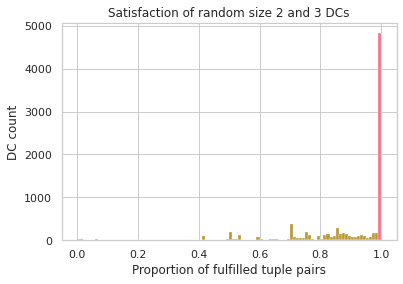

In [34]:
sns.set_theme(style="whitegrid", palette="husl")
sns.histplot(x=sSupp,bins=100,hue=[s<0.99 for s in sSupp],alpha=1,legend=False)
plt.xlabel("Proportion of fulfilled tuple pairs")
plt.ylabel("DC count")
plt.title("Satisfaction of random size 2 and 3 DCs")

Text(0.5, 1.0, 'Satisfaction of random size 2 and 3 DCs')

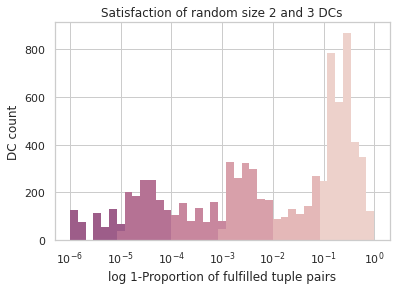

In [35]:
sns.set_theme(style="whitegrid", palette="husl")
sns.histplot(x=1-np.array(sSupp),bins=np.logspace(-6,0,40),hue=-np.floor(np.log(np.maximum(1e-10,1-np.array(sSupp)))/np.log(10)) ,alpha=1,legend=False)
plt.xlabel("log 1-Proportion of fulfilled tuple pairs")
plt.ylabel("DC count")
plt.xscale("log")
plt.title("Satisfaction of random size 2 and 3 DCs")

In [229]:
[(dc,s) for dc,s,ds in zip(dcs,sSupp,dset) if s>0.99 and s< 0.999 and datasets[ds]=='tax500k']

[(!["LName(String)" ne "LName(String)" & "AreaCode(String)" eq "AreaCode(String)"],
  0.99094),
 (!["LName(String)" ne "LName(String)" & "Phone(String)" eq "Phone(String)"],
  0.99308),
 (!["Gender(String)" eq "Gender(String)" & "AreaCode(String)" eq "AreaCode(String)"],
  0.99583),
 (!["Gender(String)" ne "Gender(String)" & "AreaCode(String)" eq "AreaCode(String)"],
  0.9957),
 (!["Gender(String)" eq "Gender(String)" & "Phone(String)" eq "Phone(String)"],
  0.99701),
 (!["Gender(String)" ne "Gender(String)" & "Phone(String)" eq "Phone(String)"],
  0.99637),
 (!["Gender(String)" eq "Gender(String)" & "State(String)" eq "State(String)"],
  0.99045),
 (!["Gender(String)" ne "Gender(String)" & "State(String)" eq "State(String)"],
  0.99012),
 (!["AreaCode(String)" eq "AreaCode(String)" & "Phone(String)" ne "Phone(String)"],
  0.99125),
 (!["AreaCode(String)" ne "AreaCode(String)" & "Phone(String)" eq "Phone(String)"],
  0.99336),
 (!["AreaCode(String)" eq "AreaCode(String)" & "City(String

In [230]:
[(dc,s) for dc,s,ds in zip(dcs,sSupp,dset) if s>0.999 and s< 0.9999 and datasets[ds]=='tax500k']

[(!["LName(String)" eq "LName(String)" & "AreaCode(String)" ne "AreaCode(String)"],
  0.99986),
 (!["LName(String)" eq "LName(String)" & "Phone(String)" ne "Phone(String)"],
  0.99989),
 (!["LName(String)" ne "LName(String)" & "City(String)" eq "City(String)"],
  0.99923),
 (!["LName(String)" eq "LName(String)" & "Zip(String)" ne "Zip(String)"],
  0.99987),
 (!["Gender(String)" eq "Gender(String)" & "City(String)" eq "City(String)"],
  0.99962),
 (!["Gender(String)" ne "Gender(String)" & "City(String)" eq "City(String)"],
  0.99954),
 (!["AreaCode(String)" eq "AreaCode(String)" & "City(String)" eq "City(String)"],
  0.99948),
 (!["AreaCode(String)" ne "AreaCode(String)" & "City(String)" eq "City(String)"],
  0.99964),
 (!["Phone(String)" ne "Phone(String)" & "City(String)" eq "City(String)"],
  0.99912),
 (!["Phone(String)" eq "Phone(String)" & "State(String)" eq "State(String)"],
  0.99989),
 (!["Phone(String)" eq "Phone(String)" & "Rate(Double)" eq "Rate(Double)"],
  0.99964),
 (!["C

In [231]:
[(dc,s) for dc,s,ds in zip(dcs,sSupp,dset) if s>0.9999 and s< 0.99999 and datasets[ds]=='tax500k']

[(!["LName(String)" eq "LName(String)" & "Gender(String)" eq "Gender(String)"],
  0.99995),
 (!["LName(String)" eq "LName(String)" & "Gender(String)" ne "Gender(String)"],
  0.99995),
 (!["LName(String)" eq "LName(String)" & "City(String)" ne "City(String)"],
  0.99997),
 (!["LName(String)" eq "LName(String)" & "State(String)" ne "State(String)"],
  0.99991),
 (!["LName(String)" ne "LName(String)" & "Zip(String)" eq "Zip(String)"],
  0.99997),
 (!["LName(String)" eq "LName(String)" & "MaritalStatus(String)" eq "MaritalStatus(String)"],
  0.99993),
 (!["LName(String)" eq "LName(String)" & "MaritalStatus(String)" ne "MaritalStatus(String)"],
  0.99997),
 (!["LName(String)" eq "LName(String)" & "HasChild(String)" eq "HasChild(String)"],
  0.99997),
 (!["LName(String)" eq "LName(String)" & "HasChild(String)" ne "HasChild(String)"],
  0.99995),
 (!["LName(String)" eq "LName(String)" & "SingleExemp(Integer)" eq "SingleExemp(Integer)"],
  0.99998),
 (!["LName(String)" eq "LName(String)" & "Si

Text(0.5, 1.0, 'Satisfaction of random size 2 and 3 DCs on true and false data')

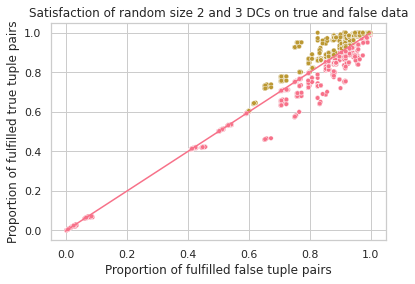

In [65]:
sns.set_theme(style="whitegrid", palette="husl")
y=1-(1-np.array(sSupp))
x=1-(1-np.array(eSupp))
c=[s<0.01 for s,ss,es in zip(stat,sSupp,eSupp)]
sns.scatterplot(y=y,x=x,hue=c,alpha=1,legend=False,s=20)
sns.lineplot(x=[1e-5,1],y=[1e-5,1])
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel("Proportion of fulfilled false tuple pairs")
plt.ylabel("Proportion of fulfilled true tuple pairs")
plt.title("Satisfaction of random size 2 and 3 DCs on true and false data")

In [66]:
with open("out.txt","w") as f:
    for k in [(dc,s,e) for dc,cc,s,e,ds in zip(dcs,c,sSupp,eSupp,dset) if cc and s==1]:
        f.write(str(k)+str('\n'))

In [62]:
sum(c)

5683

In [246]:
[ (dc,s,e,st) for dc,s,e,st in zip(dcs,sSupp,eSupp,stat) if s==1]

[(!["age int" eq "age int" & "fnlwgt int" eq "fnlwgt int"],
  1.0,
  0.9999981154989072,
  0.8282416769166095),
 (!["workclass str" eq "workclass str" & "fnlwgt int" eq "fnlwgt int"],
  1.0,
  0.9999558660200624,
  0.012112765445041014),
 (!["fnlwgt int" eq "fnlwgt int" & "education str" eq "education str"],
  1.0,
  0.9999829711632828,
  0.1821548424459709),
 (!["fnlwgt int" eq "fnlwgt int" & "Education-num int" ne "Education-num int"],
  1.0,
  0.9999289838367172,
  0.0008235646500541432),
 (!["fnlwgt int" eq "fnlwgt int" & "occupation str" eq "occupation str"],
  1.0,
  0.9999914196229498,
  0.42399170560874944),
 (!["fnlwgt int" eq "fnlwgt int" & "race str" ne "race str"],
  1.0,
  0.9999774099756271,
  0.1044519676316598),
 (!["fnlwgt int" eq "fnlwgt int" & "sex str" ne "sex str"],
  1.0,
  0.9999609889668121,
  0.02021805192884132),
 (!["fnlwgt int" eq "fnlwgt int" & "capital-loss float" ne "capital-loss float"],
  1.0,
  0.9999918698115622,
  0.4435156684375979),
 (!["fnlwgt int

In [63]:
n=100000

t0s=dss['tax500k'].randFields(n)
t1s=dss['tax500k'].randFields(n)
res=[]
rSups=[]
for dc in dcs:
    sup=dc.coverage(dss['tax500k'],t0s,t1s)
    rSups.append(sup)


NameError: name 'dss' is not defined

In [21]:
[(binom.cdf(n-n*r,n,(1-e)),binom.cdf(n-n*s,n,(1-e)),e,s,dc) for r,e,dc,s in(zip(rSups,eSupp,dcs,sSupp))]

[(0.919395655527481,
  0.13036277381786915,
  0.9999247670297968,
  0.99996,
  !["LName(String)" eq "LName(String)" & "Gender(String)" eq "Gender(String)"]),
 (0.13036955674790884,
  0.05824285620292609,
  0.9999247679702031,
  0.99997,
  !["LName(String)" eq "LName(String)" & "Gender(String)" ne "Gender(String)"]),
 (0.86813478660903,
  0.7867120694435906,
  0.5000721079702031,
  0.49882,
  !["LName(String)" ne "LName(String)" & "Gender(String)" eq "Gender(String)"]),
 (0.13328442568543084,
  0.9855225872612025,
  0.5000783570297969,
  0.49663,
  !["LName(String)" ne "LName(String)" & "Gender(String)" ne "Gender(String)"]),
 (0.8766565045335903,
  0.8766565045335903,
  0.9999986836005231,
  1.0,
  !["LName(String)" eq "LName(String)" & "AreaCode(String)" eq "AreaCode(String)"]),
 (0.5768109060445086,
  0.1904399239824422,
  0.9998508513994768,
  0.99989,
  !["LName(String)" eq "LName(String)" & "AreaCode(String)" ne "AreaCode(String)"]),
 (0.6315093786624804,
  0.4047091913712366,
  0

In [ ]:
plt.scatter(eSupp,sSupp,5,c=[x if x>0 else 0 for x in rSupp])
plt.xlabel("Expected support")
plt.ylabel("Sample Support")
plt.title("Random DCs by Relative support")
plt.plot([0,0.95,0.95],[0.9,0.98,1.02],c='red')


In [8]:
ds=Dataset("datasets/tax500k.csv")
ds.buildPLIs()

In [48]:
dc=DenialConstraint([Predicate("Zip(String)",eq,"Zip(String)")])
1-dc.expCoverage(ds)

4.731997727969173e-05

In [92]:
dc=DenialConstraint([Predicate("LName(String)",eq,"LName(String)")])
1-dc.expCoverage(ds)

0.00010199118796438977

In [93]:
dc=DenialConstraint([Predicate("AreaCode(String)",eq,"AreaCode(String)")])
1-dc.expCoverage(ds)

0.008888308693199232

In [94]:
dc=DenialConstraint([Predicate("Gender(String)",eq,"Gender(String)")])
1-dc.expCoverage(ds)

0.5000086278925115

In [63]:
dc=DenialConstraint([Predicate("State(String)",eq,"State(String)"),Predicate("Salary(Integer)",lt,"Salary(Integer)"),Predicate("Rate(Double)",gt,"Rate(Double)")])
dc.expCoverage(dss['tax500k'])
dc.sampleCoverage(dss['tax500k'],100000)
dc in [DenialConstraint([Predicate("State(String)",eq,"State(String)"),Predicate("Salary(Integer)",lt,"Salary(Integer)"),Predicate("Rate(Double)",gt,"Rate(Double)")])]

False

In [65]:
cols=ds.df.columns[[1,3,4,7,8,9,10,12]]
cols

Index(['LName(String)', 'AreaCode(String)', 'Phone(String)', 'Zip(String)',
       'MaritalStatus(String)', 'HasChild(String)', 'Salary(Integer)',
       'SingleExemp(Integer)'],
      dtype='object')

In [95]:
ops=[eq,eq,eq,eq,ne,ne,eq,ne]
res=1
for col,op in zip(cols,ops):
    dc=DenialConstraint([Predicate(col,op,col)])
    val=1-dc.expCoverage(ds)
    res*=val
    print(val)
print(res)

0.00010199118796438977
0.008888308693199232
0.0002587584070325999
4.731997727969173e-05
0.49999533652334616
0.499995433739735
0.0050017980671722695
0.5879416090040843
8.160431409227706e-18


In [93]:
p=Predicate("Zip(String)",ne,"Zip(String)")
gen=p.sample(ds)
for i in range(20000):
    #
    (next(gen))
    print(i)
    pass
print(next(gen))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [40]:
np.random.choice([1,2,3],2,replace=False,p=[0,0.1,0.9])

array([2, 3])

## Algorithm

In [8]:
from scipy.stats import beta,binom
ds=Dataset("datasets/tax500k.csv")
ds.buildPLIs()

In [9]:
def enumPreds(df):
    preds=[]
    for col in df.df.columns:

        ops=[eq,ne,gt,lt] if df.df[col].dtype==float else [eq,ne] 
        for op in ops:
            preds.append(Predicate(col,op,col))
    exps=[pred.expected(df) for pred in preds]

    order =sorted(range(len(preds)),key=lambda i:exps[i])

    preds=[preds[i] for i in order]
    exps=[exps[i] for i in order]
    return preds,exps
preds,exps=enumPreds(ds)

In [13]:
n=10000
minSup=0.00
res=[]
def search(DC,i0,t0s,t1s,neg,prob):
    leaf=True
    if len(res)>10:
        return
    for i in range(i0,len(preds)):
        pred=preds[i]
        exp=exps[i]
        if pred.l in [p.l for p in DC]:
            continue
        if len(DC)==0:
            leaf=False
            gen=pred.sample(ds)
            tps= [next(gen) for _ in range(n)] 

            t0s=[tp[0] for tp in tps]
            t1s=[tp[1] for tp in tps]

            t0s=ds.df.loc[t0s].reset_index()
            t1s=ds.df.loc[t1s].reset_index()
            ex=pred.expected(ds)
            neg=n*(1-ex)/ex
            search([pred],i+1,t0s,t1s,neg,1)
        else:
            dc=DenialConstraint(DC+[pred])
            pos=(1-dc.coverage(ds,t0s,t1s))*n
            
            a=pos
            b=n-pos +neg

            ex=(1-dc.expCoverage(ds))

            pr=1-beta.cdf(ex,a,b)

            pr2=binom.cdf(0,n,ex)

            if pr<prob and pr2>0.01:
                leaf=False
                search(DC+[pred],i+1,t0s,t1s,neg,pr)

    if leaf:
        res.append((DC,prob))       

search([],0,None,None,None,None)
res      

In [131]:
res

[["Zip(String)" eq "Zip(String)", "LName(String)" eq "LName(String)"],
 ["Zip(String)" eq "Zip(String)", "FName(String)" eq "FName(String)"],
 ["Zip(String)" eq "Zip(String)", "Phone(String)" eq "Phone(String)"],
 ["Zip(String)" eq "Zip(String)", "Salary(Integer)" eq "Salary(Integer)"],
 ["Zip(String)" eq "Zip(String)",
  "MarriedExemp(Integer)" gt "MarriedExemp(Integer)",
  "ChildExemp(Integer)" eq "ChildExemp(Integer)"],
 ["Zip(String)" eq "Zip(String)",
  "MarriedExemp(Integer)" gt "MarriedExemp(Integer)",
  "HasChild(String)" eq "HasChild(String)"],
 ["Zip(String)" eq "Zip(String)",
  "MarriedExemp(Integer)" gt "MarriedExemp(Integer)",
  "Rate(Double)" ne "Rate(Double)",
  "AreaCode(String)" ne "AreaCode(String)"],
 ["Zip(String)" eq "Zip(String)",
  "MarriedExemp(Integer)" gt "MarriedExemp(Integer)",
  "AreaCode(String)" ne "AreaCode(String)"],
 ["Zip(String)" eq "Zip(String)",
  "MarriedExemp(Integer)" lt "MarriedExemp(Integer)",
  "ChildExemp(Integer)" eq "ChildExemp(Integer)",


In [116]:
beta.cdf(0.666666666,20000000000000000,10000000000000000)

0.2506936617201981

In [69]:
for i,j in np.ones((10,2)):
    print(i+j)

2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
